# Discovering chemicals in patents by assessing their findability
 Prevalent sections in patent documents capturing compound information

# Import Modules

In [1]:
import os
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()

# Add path constants

In [2]:
FIG_DIR = '../data/figures'
DATA_DIR = '../data/raw'
os.makedirs(FIG_DIR, exist_ok=True)

# Load data file

In [3]:
surechembl_df = pd.read_parquet(f'{DATA_DIR}/surechembl_dump.pq')
surechembl_df.head(2)

,SureChEMBL_ID,SMILES,InChIKey,PATENT_ID,PUBLICATION_DATE,Field
0,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2842582-A2,2015-03-04,Description
1,SCHEMBL4,C[C@H](CS)C(=O)N1CCC[C@H]1C(O)=O,FAKRSMQSSFJEIM-RQJHMYQMSA-N,EP-2838373-A2,2015-02-25,Description


# Filtering unique compounds per year

In [4]:
surechembl_df['year'] = surechembl_df['PUBLICATION_DATE'].progress_apply(lambda x: x.split('-')[0])

100%|██████████| 133512452/133512452 [04:24<00:00, 505406.32it/s]


In [5]:
# Drop duplicate entries
surechembl_df = surechembl_df.drop_duplicates(subset=["InChIKey", "year"], keep='first')
surechembl_df.shape

(21857225, 7)

# Calculate Fields for unique compounds per year

In [6]:
field_count_df = pd.DataFrame(surechembl_df['Field'].value_counts()).reset_index()
field_count_df.rename(columns={'index': 'Field', 'Field': 'count'}, inplace=True)
field_count_df

,Field,count
0,Image (for patents after 2007),9400687
1,Description,9188916
2,Claims,2005059
3,MOL Attachment (US patents after 2007),1239389
4,Abstract,17468
5,Title,5706


In [7]:
rename_vals = {
    'Image (for patents after 2007)': 'Image',
    'MOL Attachment (US patents after 2007)': 'MOL file'
}
field_count_df['Field'] = field_count_df['Field'].progress_map(lambda x: rename_vals[x] if x in rename_vals else x)

100%|██████████| 6/6 [00:00<00:00, 849.59it/s]


# Visualisation

In [8]:
total_count = field_count_df['count'].sum()

In [9]:
sns.set_style("whitegrid")

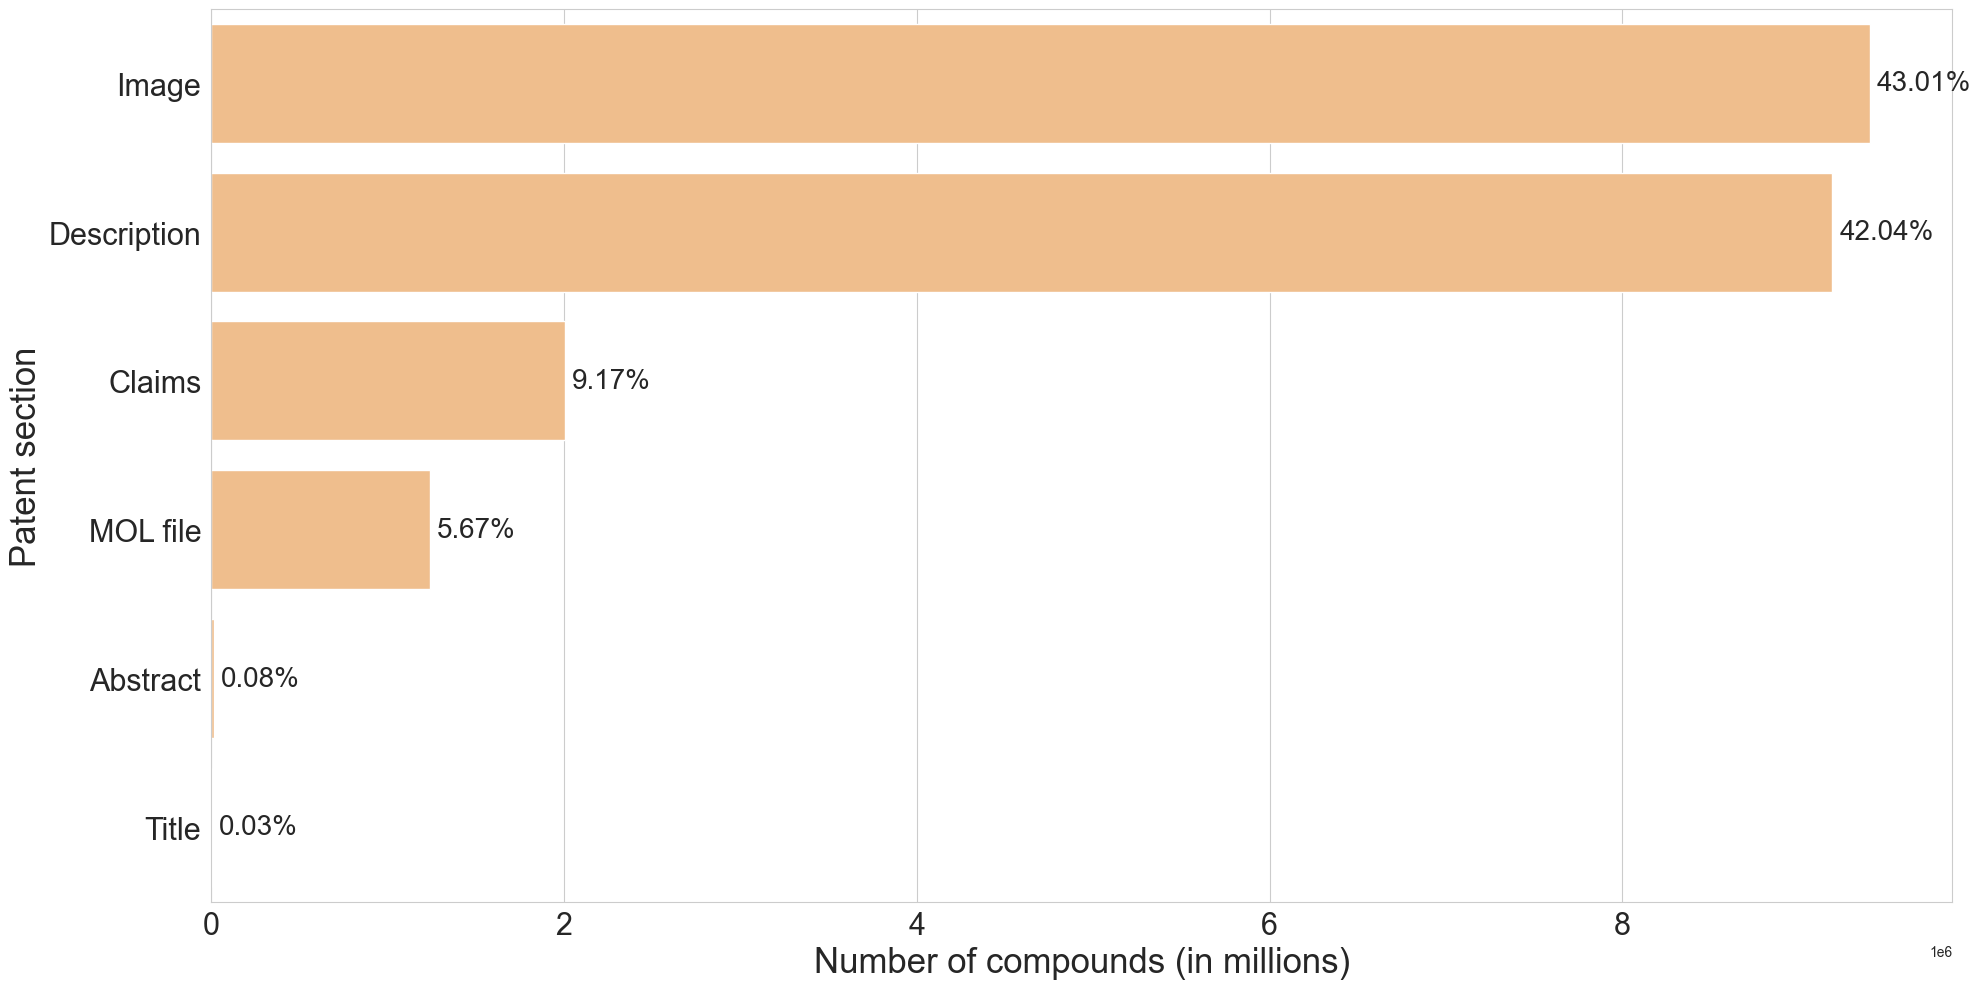

In [10]:
plt.figure(figsize=(20, 10)) 
ax = sns.barplot(
    data=field_count_df, 
    x='count', 
    y='Field',
    orient='h', 
    color='#ffbe7d'
)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel("Number of compounds (in millions)", fontsize=25)
plt.ylabel("Patent section", fontsize=25)

for p in ax.patches:
    t = (p.get_width() / total_count) * 100
    ax.annotate(
        "%.2f" % t + "%",
        xy=(p.get_width(), p.get_y()+p.get_height()/2),
        xytext=(5, 0), 
        textcoords='offset points', 
        ha="left", 
        va="center",
        fontsize=20
    )
plt.tight_layout()
plt.savefig(f'{FIG_DIR}/figure_3.png', dpi=400)
plt.show()